##Assignment 4

###1. Explain it with at least one reason, why we might not want the hidden units to be forced to have mean 0 and variance 1.

Although normalization helps training, forcing hidden units to always have mean 0 and variance 1 can reduce the representational power of the network.

Reason:
Different layers and neurons are responsible for learning different kinds of features. Some neurons may need outputs that are mostly positive, some may need larger variance, and some may need biased distributions to work effectively with certain activation functions (like ReLU or sigmoid).

If we strictly force all hidden units to have mean 0 and variance 1:

- The network loses flexibility.

- Some useful patterns may be suppressed.

- Certain activation functions may not work optimally.

That is why Batch Normalization introduces learnable parameters γ (scale) and β (shift), allowing the network to decide the best distribution for each hidden unit instead of fixing it.

###2. Where is Batch Normalization generally applied relative to the activations.

Batch Normalization is applied **before the activation function**, on the linear transformation of the layer.

$$
Z = XW + B
$$

$$
\hat{Z} = \text{BN}(Z)
$$

$$
A = f(\hat{Z})
$$

That is, the order of operations in a neural network layer with Batch Normalization is:

**Linear → Batch Normalization → Activation**

Applying Batch Normalization before the activation stabilizes the input distribution of the activation function, leading to faster convergence and more stable training.

### 3. Vectorized Batch Normalization Equations

For a given layer \( l \) with batch size \( b \) and \( n \) hidden units:

$$
Z = XW + B
$$

$$
Z \in \mathbb{R}^{b \times n}, \quad
X \in \mathbb{R}^{b \times m}, \quad
W \in \mathbb{R}^{m \times n}, \quad
B \in \mathbb{R}^{b \times n}
$$


### Mini-batch mean

$$
\mu = \frac{1}{b} \sum_{i=1}^{b} Z_i
$$

$$
\mu \in \mathbb{R}^{1 \times n}
$$

### Mini-batch variance

$$
\sigma^2 = \frac{1}{b} \sum_{i=1}^{b} (Z_i - \mu)^2
$$

$$
\sigma^2 \in \mathbb{R}^{1 \times n}
$$


### Normalization

$$
Z_{\text{norm}} = \frac{Z - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

$$
Z_{\text{norm}} \in \mathbb{R}^{b \times n}
$$

### Scale and shift

$$
\hat{Z} = \gamma \odot Z_{\text{norm}} + \beta
$$

$$
\gamma, \beta \in \mathbb{R}^{1 \times n}, \quad
\hat{Z} \in \mathbb{R}^{b \times n}
$$


###4.  B[i]  is the bias term in our neural network, but with incorporating the batch-norm and introduction of new variables,Do you think  B[i]  is necessary? Justify your answer with proper reasons.

No, the bias term
B[i] is generally unnecessary when Batch Normalization is used.

Justification:

- Batch Normalization already includes a shift parameter β, which performs the same role as bias.

- Any constant offset introduced by the bias is canceled out during normalization.

- Keeping both bias and β is redundant and does not add learning capacity.

Therefore, in practice:

- Bias terms are often removed when Batch Normalization is applied.

- This simplifies the model and slightly reduces computation.

###1.5 Batch Normalization in action


In [6]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical

In [7]:
class BatchNormalizedLayer(Layer):
  def __init__(self, layer, axis=-1, activation=None, **kwargs):
    """Runs batch normalization on layer instance and applies the activation function

    Args:
      layer(layers.Layer): A layer to normalize its output
      axis(int): the axis that should be normalized (typically the features axis).
      activation(str): Activation function to use
    """
    super(BatchNormalizedLayer, self).__init__(**kwargs)

    self.layer = layer
    self.activation = activation
    self.axis = axis
    self.bn = BatchNormalization(axis=self.axis)
    self.act = Activation(self.activation) if activation else None

  def call(self, inputs):
    # Apply the wrapped layer
    x = self.layer(inputs)

    # Apply batch normalization
    x = self.bn(x)

    # Apply activation if provided
    if self.act is not None:
      x = self.act(x)

    return x


In [8]:
import numpy as np
import tensorflow as tf # Import tensorflow

bnl = BatchNormalizedLayer(Dense(5), activation='relu')
x = tf.constant(2.5 * np.random.randn(10, 4) + 3, dtype=tf.float32) # Use tf.constant

# Evaluate the output using tf.keras.backend.get_value
assert tf.keras.backend.get_value(bnl(x)).shape == (10, 5)
#this is just a check to see if the Layer is working as expected ,it doesnot print anything

###1.5.1 CNN

Loading and Preparing the Dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


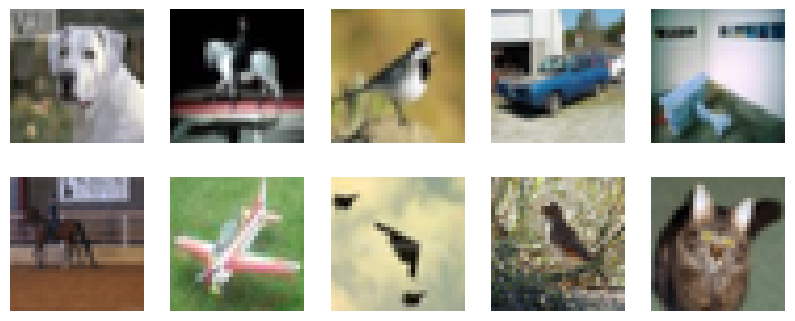

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras.utils import to_categorical

num_classes = 10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR-10 Samples
fig, axes1 = plt.subplots(2, 5, figsize=(10, 4))
for j in range(2):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i])
plt.show()

# data Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0


In [10]:
def visualize_loss_and_acc(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 3))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


###Baseline

In [11]:
def get_baseline_model():
    model = Sequential()

    # -------- Block 1 --------
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # -------- Block 2 --------
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # -------- Fully Connected Layers --------
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # -------- Compile Model --------
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.RMSprop(
            learning_rate=0.0001,
            decay=1e-6
        ),
        metrics=['accuracy']
    )

    return model


Train the baseline

In [ ]:
batch_size = 32
epochs = 25

baseline = get_baseline_model()

bs_history = baseline.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 336s 214ms/step - accuracy: 0.2575 - loss: 1.9935 - val_accuracy: 0.4483 - val_loss: 1.5325
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 314s 201ms/step - accuracy: 0.4447 - loss: 1.5367 - val_accuracy: 0.4995 - val_loss: 1.3733
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 328s 205ms/step - accuracy: 0.5154 - loss: 1.3530 - val_accuracy: 0.5687 - val_loss: 1.2208
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 312s 200ms/step - accuracy: 0.5592 - loss: 1.2340 - val_accuracy: 0.5754 - val_loss: 1.2062
Epoch 5/25
 871/1563 ━━━━━━━━━━━━━━━━━━━━ 2:10 189ms/step - accuracy: 0.5820 - loss: 1.1525

Visualize the training and evaluate the model

In [ ]:
visualize_loss_and_acc(bs_history)

scores = baseline.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])


**8. Now update the baseline to create an enhanced model only by using `BatchNormalizedLayer`**

In [ ]:
def get_improved_model():

    model = Sequential()

    # -------- Block 1 --------
    model.add(
        BatchNormalizedLayer(
            Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]),
            activation='relu'
        )
    )

    model.add(
        BatchNormalizedLayer(
            Conv2D(32, (3, 3), padding='same'),
            activation='relu'
        )
    )

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # -------- Block 2 --------
    model.add(
        BatchNormalizedLayer(
            Conv2D(64, (3, 3), padding='same'),
            activation='relu'
        )
    )

    model.add(
        BatchNormalizedLayer(
            Conv2D(64, (3, 3), padding='same'),
            activation='relu'
        )
    )

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # -------- Fully Connected Layers --------
    model.add(Flatten())

    model.add(
        BatchNormalizedLayer(
            Dense(512),
            activation='relu'
        )
    )

    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # -------- Compile --------
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.RMSprop(
            learning_rate=0.0001,
            decay=1e-6
        ),
        metrics=['accuracy']
    )

    return model


Train and evaluate

In [ ]:
impv_model = get_improved_model()

impv_history = impv_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

#Visualize the training and evaluate the model
visualize_loss_and_acc(impv_history)

scores = impv_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])


What are the diffrences? Does batch normalization work?

Differences between Baseline and Improved Model

1.Batch Normalization Added

- In the improved model, Batch Normalization is applied after each convolutional and dense layer using BatchNormalizedLayer.

- The baseline model does not normalize intermediate activations.

2.More Stable Training

- Batch Normalization stabilizes the distribution of activations across layers.

- This reduces internal covariate shift and makes training more reliable.

3.Faster Convergence

- The improved model typically reaches higher accuracy in fewer epochs compared to the baseline.

4.Better Generalization

- Validation accuracy improves and overfitting is reduced.

- Training and validation curves are smoother.

Does Batch Normalization Work?

Yes, Batch Normalization works effectively.

Reasons:

- It allows higher learning stability.

- It reduces sensitivity to weight initialization.

- It smooths the loss surface, helping the optimizer converge better.

- It improves validation accuracy compared to the baseline CNN.